# Quora Question pairs


Today it's a preparation for delivery 1.


The objective of today is to build a solution for:

https://www.kaggle.com/c/quora-question-pairs/overview

You might even make a late submission to kaggle to know how well you would have done in the competition.



In [1]:
import pandas as pd
import scipy
import sklearn
from sklearn import *
import numpy as np
import os

df = pd.read_csv("./quora_train_data.csv")
train, valid = sklearn.model_selection.train_test_split(df, test_size=0.05, random_state=123)

# Improving feature vectors:
Build a Similarity metric between documents using the tf-idf vectors of the documents.

Build a class from scratch that can learn a tf-idf feature representation.

In [2]:
from utils import TfIdfCustomVectorizer, TfIdfEmbeddingVectorizer, preprocess
from gensim.models import Word2Vec

First we are going to train a Word2Vec model, so that it better fits our problem.

In [3]:
all_questions = list(train["question1"]) + list(train["question2"])

In [4]:
from utils import TfIdfEmbeddingVectorizer

vectorizer = TfIdfEmbeddingVectorizer().fit(all_questions)

X_train_q1 = vectorizer.transform(train['question1'])
X_train_q2 = vectorizer.transform(train['question2'])

In [24]:
X_valid_q1 = vectorizer.transform(valid['question1'])
X_valid_q2 = vectorizer.transform(valid['question2'])

In [15]:
def cosine(X, Y):
    norm = (np.linalg.norm(X, axis=1) * np.linalg.norm(Y, axis=1))
    return 1 - np.einsum('ij,ij->i', X, Y) / np.where(norm==0, 1, norm)

def manhattan(X, Y):
    return np.linalg.norm(X - Y, ord=1, axis=1)

def euclid(X, Y):
    return np.linalg.norm(X - Y, ord=2, axis=1)

X_train_dist_cos = cosine(X_train_q1, X_train_q2)
X_train_dist_man = manhattan(X_train_q1, X_train_q2)
X_train_dist_euc = euclid(X_train_q1, X_train_q2)

In [25]:
X_valid_dist_cos = cosine(X_valid_q1, X_valid_q2)
X_valid_dist_man = manhattan(X_valid_q1, X_valid_q2)
X_valid_dist_euc = euclid(X_valid_q1, X_valid_q2)

In [27]:
from matplotlib import pyplot as plt

def tpr_fpr(p, dist, y_true):
    accurate = y_true == (dist < p)
    tpr = accurate[y_true == 1].mean()
    fpr = 1 - accurate[y_true == 0].mean()
    return tpr, fpr

y = valid['is_duplicate'].to_numpy()
roc_cos = [tpr_fpr(p, X_valid_dist_cos, y) for p in np.linspace(0, 1, 1000)]
roc_man = [tpr_fpr(p, X_valid_dist_man, y) for p in np.linspace(0, X_valid_dist_man.max(), 1000)]
roc_euc = [tpr_fpr(p, X_valid_dist_euc, y) for p in np.linspace(0, X_valid_dist_euc.max(), 1000)]

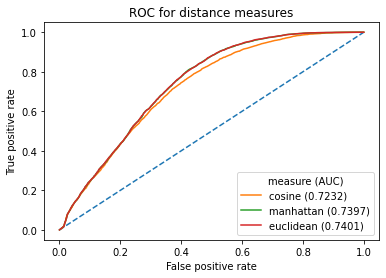

In [39]:
plt.plot([0,1],[0,1], '--')

tpr, fpr = zip(*roc_cos)
plt.plot(fpr, tpr, label='cosine ({:.4f})'.format(metrics.auc(fpr, tpr)))

tpr, fpr = zip(*roc_man)
plt.plot(fpr, tpr, label='manhattan ({:.4f})'.format(metrics.auc(fpr, tpr)))

tpr, fpr = zip(*roc_euc)
plt.plot(fpr, tpr, label='euclidean ({:.4f})'.format(metrics.auc(fpr, tpr)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC for distance measures')
plt.legend(title='measure (AUC)')
plt.savefig('img/roc.pdf')

In [19]:
tpr, fpr = zip(*roc_euc)
metrics.auc(fpr, tpr)

0.7416772167128238

In [30]:
vals = [(y == (X_valid_dist_cos < p)).mean() for p in np.linspace(0, 1, 1000)]

In [31]:
max(vals)

0.666955231263913